# Segundo entregable: Clasificación
## 1. El Dilema del lado <font color='#FF0000'> Rojo </font>

Históricamente, el lado azul siempre ha tenido un winrate algo superior al lado rojo (+1.2%)[1]. Es un tema que genera controversia entre los analistas de League of Legends, sobretodo en la faceta más competitiva de este. Se han desarrollado muchas teorías de la razón detrás del desbalance (ángulo de la cámara, distribución del mapa, ubicación de los objectivos neutrales...). Aun así, la comunidad ha llegado a la conclusión que esa diferencia de winrate viene dada por la "ventaja" que tiene el lado azul de escoger primero, sumado al meta actual del juego. Si en el meta actual hay más de 3 Power picks, el lado rojo no los puede banear a todos. 

 
Dicho esto, nuestro objetivo para esta entrega es, dado datos de ligas competitivas, ayudar al lado rojo a escoger la mejor estrategia para ganar. Para ello, no solo crearemos un modelo de clasificación, sino que encontraremos las mejores variables que se ajusten a ello, para así determinar que tipo de estrategia se puede usar desde el lado rojo para ganar la desventaja inicial que estos tienen.



## 2. Desarrollo

### 2.1 Procesado inicial
#### - Limpieza

#### Carga de paquetes

In [240]:
import os
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import pickle
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from sklearn import tree

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict

from sklearn.decomposition import PCA


#### Obtención de los datos

In [241]:
'''
    Takes the JSON files for the matches' data, extracts the relevant features and saves
    all of it in tabular form
'''

np.seterr(divide='ignore', invalid='ignore')
start = time.time()
total_matches = 0

# giving directory name
dirname = './collected_data'
 
# giving file extension
ext = '.json'

# name and location of file to save
final_filename = "./data_all.csv"

# creating an empty list to save the data in, and then create the dataframe
to_save = []
 
# iterating over all files
for file in os.listdir(dirname):
    if file.endswith(ext) and '_matches_' in file:
        with open(os.path.join(dirname,file), "r") as jfile:

            data = json.load(jfile)
            data = data["match_data"]

            print(f">> Working through the data in: {file} <<")

            # begin extracting the features for each match in the file
            for m in tqdm(data):

                if m["gameMode"] != 'CLASSIC':
                    continue
                else:
                    # upated running game count
                    total_matches += 1


                    if m["platformId"] == "EUW1":
                        region = 0
                    elif m["platformId"] == "NA1":
                        region = 1
                    else:
                        region = 2

                    
                    # flag for which side won (0=blue, 1=red)
                    winning_team = 0 if m["teams"][0]["win"] else 1

                    # info for total objectives taken by either sides
                    blue_turrets    = m["teams"][0]["objectives"]["tower"]["kills"]
                    blue_barons     = m["teams"][0]["objectives"]["baron"]["kills"]
                    blue_drakes     = m["teams"][0]["objectives"]["dragon"]["kills"]
                    blue_kills      = m["teams"][0]["objectives"]["champion"]["kills"]
                    blue_inhibs     = m["teams"][0]["objectives"]["inhibitor"]["kills"]
                    blue_heralds    = m["teams"][0]["objectives"]["riftHerald"]["kills"]
                    try:
                        total_blue_elders = m["participants"][0]["challenges"]["teamElderDragonKills"]
                    except KeyError:
                        continue #total_blue_barons = 0

                    red_turrets    = m["teams"][1]["objectives"]["tower"]["kills"]
                    red_barons     = m["teams"][1]["objectives"]["baron"]["kills"]
                    red_drakes     = m["teams"][1]["objectives"]["dragon"]["kills"]
                    red_kills      = m["teams"][1]["objectives"]["champion"]["kills"]
                    red_inhibs     = m["teams"][1]["objectives"]["inhibitor"]["kills"]
                    red_heralds    = m["teams"][1]["objectives"]["riftHerald"]["kills"]
                    try:
                        total_red_elders = m["participants"][5]["challenges"]["teamElderDragonKills"]
                    except KeyError:
                        continue #total_red_elders = 0
                    
                    # info for first major objectives taken by either side (boolean flag)
                    blue_first_blood    = float(m["teams"][0]["objectives"]["champion"]["first"])
                    blue_first_herald   = float(m["teams"][0]["objectives"]["riftHerald"]["first"])
                    blue_first_drake    = float(m["teams"][0]["objectives"]["dragon"]["first"])
                    blue_first_baron    = float(m["teams"][0]["objectives"]["baron"]["first"])
                    blue_first_inhib    = float(m["teams"][0]["objectives"]["inhibitor"]["first"])
                    blue_first_turret   = float(m["teams"][0]["objectives"]["tower"]["first"])
                    # to have soul, the team should have four drakes total not counting elders, i.e.:
                    blue_got_soul = float(m["teams"][0]["objectives"]["dragon"]["kills"] - total_blue_elders == 4)

                    red_first_blood    = float(m["teams"][1]["objectives"]["champion"]["first"])
                    red_first_herald   = float(m["teams"][1]["objectives"]["riftHerald"]["first"])
                    red_first_drake    = float(m["teams"][1]["objectives"]["dragon"]["first"])
                    red_first_baron    = float(m["teams"][1]["objectives"]["baron"]["first"])
                    red_first_inhib    = float(m["teams"][1]["objectives"]["inhibitor"]["first"])
                    red_first_turret   = float(m["teams"][1]["objectives"]["tower"]["first"])
                    # to have soul, the team should have four drakes total not counting elders, i.e.:
                    red_got_soul = float(m["teams"][1]["objectives"]["dragon"]["kills"] - total_red_elders == 4)

                    # info for stats and objectives taken by each player in either side - init
                    blue_player_kills   = []
                    blue_player_xp      = []
                    blue_player_gold    = []
                    blue_player_dmg     = []
                    blue_player_vs      = []
                    blue_player_spells  = []
                    blue_turret_takedowns = []
                    blue_damage_dealt_to_objectives = []
                    
                    red_player_kills   = []
                    red_player_xp      = []
                    red_player_gold    = []
                    red_player_dmg     = []
                    red_player_vs      = []
                    red_player_spells  = []
                    red_turret_takedowns = []
                    red_damage_dealt_to_objectives = []

                    # loop through players to add above data
                    for p in m["participants"]:
                        if p["teamId"] == 100:      # blue side
                            blue_player_kills.append(p["kills"])
                            blue_player_xp.append(p["champExperience"])
                            blue_player_gold.append(p["goldEarned"])
                            blue_player_dmg.append(p["totalDamageDealtToChampions"])
                            blue_player_vs.append(p["visionScore"])
                            blue_player_spells.append(p["spell1Casts"]+p["spell2Casts"]+p["spell3Casts"]+p["spell4Casts"])
                            blue_turret_takedowns.append(p["turretTakedowns"])
                            blue_damage_dealt_to_objectives.append(p["damageDealtToObjectives"])
                        elif p["teamId"] == 200:    # red side
                            red_player_kills.append(p["kills"])
                            red_player_xp.append(p["champExperience"])
                            red_player_gold.append(p["goldEarned"])
                            red_player_dmg.append(p["totalDamageDealtToChampions"])
                            red_player_vs.append(p["visionScore"])
                            red_player_spells.append(p["spell1Casts"]+p["spell2Casts"]+p["spell3Casts"]+p["spell4Casts"])
                            red_turret_takedowns.append(p["turretTakedowns"])
                            red_damage_dealt_to_objectives.append(p["damageDealtToObjectives"])
                    
                    # calculations for actual features
                    total_blue_kills    = blue_kills / (red_kills + blue_kills) if (red_kills + blue_kills) != 0 else 0
                    total_red_kills     = red_kills / (red_kills + blue_kills) if (red_kills + blue_kills) != 0 else 0

                    total_blue_barons   = blue_barons / (red_barons + blue_barons) if (red_barons + blue_barons) != 0 else 0
                    total_red_barons    = red_barons / (red_barons + blue_barons) if (red_barons + blue_barons) != 0 else 0

                    total_blue_turrets  = blue_turrets / (red_turrets + blue_turrets) if (red_turrets + blue_turrets) != 0 else 0
                    total_red_turrets   = red_turrets / (red_turrets + blue_turrets) if (red_turrets + blue_turrets) != 0 else 0

                    total_blue_drakes   = blue_drakes / (red_drakes + blue_drakes) if (red_drakes + blue_drakes) != 0 else 0
                    total_red_drakes    = red_drakes / (red_drakes + blue_drakes) if (red_drakes + blue_drakes) != 0 else 0

                    total_blue_inhibs   = blue_inhibs / (red_inhibs + blue_inhibs) if (red_inhibs + blue_inhibs) != 0 else 0
                    total_red_inhibs    = red_inhibs / (red_inhibs + blue_inhibs) if (red_inhibs + blue_inhibs) != 0 else 0

                    total_blue_heralds  = blue_heralds / (red_heralds + blue_heralds) if (red_heralds + blue_heralds) != 0 else 0
                    total_red_heralds   = red_heralds / (red_heralds + blue_heralds) if (red_heralds + blue_heralds) != 0 else 0

                    total_blue_gold     = np.sum(blue_player_gold) / (np.sum(blue_player_gold) + np.sum(red_player_gold))
                    total_red_gold      = np.sum(red_player_gold) / (np.sum(blue_player_gold) + np.sum(red_player_gold))

                    total_blue_elders   = total_blue_elders / (total_blue_elders + total_red_elders) if total_blue_elders != 0 else 0
                    total_red_elders    = total_red_elders / (total_blue_elders + total_red_elders) if total_red_elders != 0 else 0

                    total_blue_vs     = np.sum(blue_player_vs) / (np.sum(blue_player_vs) + np.sum(red_player_vs))
                    total_red_vs      = np.sum(red_player_vs) / (np.sum(blue_player_vs) + np.sum(red_player_vs))

                    total_blue_spells     = np.sum(blue_player_spells) / (np.sum(blue_player_spells) + np.sum(red_player_spells))
                    total_red_spells      = np.sum(red_player_spells) / (np.sum(blue_player_spells) + np.sum(red_player_spells))

                    total_blue_turret_takedowns     = np.sum(blue_turret_takedowns) / (np.sum(blue_turret_takedowns) + np.sum(red_turret_takedowns))
                    total_red_turret_takedowns      = np.sum(red_turret_takedowns) / (np.sum(blue_turret_takedowns) + np.sum(red_turret_takedowns))

                    total_blue_damage_dealt_to_objectives     = np.sum(blue_damage_dealt_to_objectives) / (np.sum(blue_damage_dealt_to_objectives) + np.sum(red_damage_dealt_to_objectives))
                    total_red_damage_dealt_to_objectives      = np.sum(red_damage_dealt_to_objectives) / (np.sum(blue_damage_dealt_to_objectives) + np.sum(red_damage_dealt_to_objectives))

                    # calculations of indivudal player-based medians
                    med_blue_kills  = [0,0,0,0,0]
                    med_red_kills   = [0,0,0,0,0]
                    for k in range(5):
                        if (blue_player_kills[k] + red_player_kills[k]) != 0:
                            med_blue_kills[k]   = blue_player_kills[k] / (blue_player_kills[k] + red_player_kills[k])
                            med_red_kills[k]    = red_player_kills[k] / (blue_player_kills[k] + red_player_kills[k])
                    med_blue_kills  = np.median(med_blue_kills)
                    med_red_kills   = np.median(med_red_kills)

                    med_blue_xp  = [0,0,0,0,0]
                    med_red_xp   = [0,0,0,0,0]
                    for k in range(5):
                        if (blue_player_xp[k] + red_player_xp[k]) != 0:
                            med_blue_xp[k]   = blue_player_xp[k] / (blue_player_xp[k] + red_player_xp[k])
                            med_red_xp[k]    = red_player_xp[k] / (blue_player_xp[k] + red_player_xp[k])
                    med_blue_xp  = np.median(med_blue_xp)
                    med_red_xp   = np.median(med_red_xp)

                    med_blue_gold  = [0,0,0,0,0]
                    med_red_gold   = [0,0,0,0,0]
                    for k in range(5):
                        if (blue_player_gold[k] + red_player_gold[k]) != 0:
                            med_blue_gold[k]   = blue_player_gold[k] / (blue_player_gold[k] + red_player_gold[k])
                            med_red_gold[k]    = red_player_gold[k] / (blue_player_gold[k] + red_player_gold[k])
                    med_blue_gold  = np.median(med_blue_gold)
                    med_red_gold   = np.median(med_red_gold)

                    med_blue_dmg  = [0,0,0,0,0]
                    med_red_dmg   = [0,0,0,0,0]
                    for k in range(5):
                        if (blue_player_dmg[k] + red_player_dmg[k]) != 0:
                            med_blue_dmg[k]   = blue_player_dmg[k] / (blue_player_dmg[k] + red_player_dmg[k])
                            med_red_dmg[k]    = red_player_dmg[k] / (blue_player_dmg[k] + red_player_dmg[k])
                    med_blue_dmg  = np.median(med_blue_dmg)
                    med_red_dmg   = np.median(med_red_dmg)

                    med_blue_vs  = [0,0,0,0,0]
                    med_red_vs   = [0,0,0,0,0]
                    for k in range(5):
                        if (blue_player_vs[k] + red_player_vs[k]) != 0:
                            med_blue_vs[k]   = blue_player_vs[k] / (blue_player_vs[k] + red_player_vs[k])
                            med_red_vs[k]    = red_player_vs[k] / (blue_player_vs[k] + red_player_vs[k])
                    med_blue_vs  = np.median(med_blue_vs)
                    med_red_vs   = np.median(med_red_vs)

                    med_blue_spells  = [0,0,0,0,0]
                    med_red_spells   = [0,0,0,0,0]
                    for k in range(5):
                        if (blue_player_spells[k] + red_player_spells[k]) != 0:
                            med_blue_spells[k]   = blue_player_spells[k] / (blue_player_spells[k] + red_player_spells[k])
                            med_red_spells[k]    = red_player_spells[k] / (blue_player_spells[k] + red_player_spells[k])
                    med_blue_spells  = np.median(med_blue_spells)
                    med_red_spells   = np.median(med_red_spells)

                    med_blue_turrets_takedowns  = [0,0,0,0,0]
                    med_red_turrets_takedowns   = [0,0,0,0,0]
                    for k in range(5):
                        if (blue_turret_takedowns[k] + red_turret_takedowns[k]) != 0:
                            med_blue_turrets_takedowns[k]   = blue_turret_takedowns[k] / (blue_turret_takedowns[k] + red_turret_takedowns[k])
                            med_red_turrets_takedowns[k]    = red_turret_takedowns[k] / (blue_turret_takedowns[k] + red_turret_takedowns[k])
                    med_blue_turrets_takedowns  = np.median(med_blue_turrets_takedowns)
                    med_red_turrets_takedowns   = np.median(med_red_turrets_takedowns)

                    med_blue_damage_dealt_to_objectives  = [0,0,0,0,0]
                    med_red_damage_dealt_to_objectives   = [0,0,0,0,0]
                    for k in range(5):
                        if (blue_damage_dealt_to_objectives[k] + red_damage_dealt_to_objectives[k]) != 0:
                            med_blue_damage_dealt_to_objectives[k]   = blue_damage_dealt_to_objectives[k] / (blue_damage_dealt_to_objectives[k] + red_damage_dealt_to_objectives[k])
                            med_red_damage_dealt_to_objectives[k]    = red_damage_dealt_to_objectives[k] / (blue_damage_dealt_to_objectives[k] + red_damage_dealt_to_objectives[k])
                    med_blue_damage_dealt_to_objectives  = np.median(med_blue_damage_dealt_to_objectives)
                    med_red_damage_dealt_to_objectives   = np.median(med_red_damage_dealt_to_objectives)

                    row = [total_blue_barons,total_blue_drakes,total_blue_heralds,total_blue_inhibs,total_blue_kills,total_blue_turrets,
                        blue_first_blood, blue_first_herald, blue_first_drake, blue_first_baron, blue_first_inhib, blue_first_turret, total_blue_vs,
                        total_blue_spells,total_blue_gold, total_blue_turret_takedowns,total_blue_damage_dealt_to_objectives, med_blue_kills, med_blue_xp, med_blue_gold, med_blue_dmg, blue_got_soul, total_blue_elders, med_blue_vs,
                        med_blue_spells,med_blue_turrets_takedowns,med_blue_damage_dealt_to_objectives,total_red_barons, total_red_drakes, total_red_heralds, total_red_inhibs, total_red_kills, total_red_turrets,
                        red_first_blood, red_first_herald, red_first_drake, red_first_baron, red_first_inhib, red_first_turret, total_red_vs,
                        total_red_spells,total_red_gold,total_red_turret_takedowns,total_red_damage_dealt_to_objectives, med_red_kills, med_red_xp, med_red_gold, med_red_dmg, red_got_soul, total_red_elders, med_red_vs,
                        med_red_spells,med_red_turrets_takedowns,med_red_damage_dealt_to_objectives,winning_team,region]
                    
                    to_save.append(row)

            # save current state for backup if needed
            with open('df_list.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
                pickle.dump([to_save], f)

print(">> Going to save data to DataFrame <<")
cols = ["total_blue_barons", "total_blue_drakes", "total_blue_heralds", "total_blue_inhibs", "total_blue_kills", "total_blue_turrets",
       "blue_first_blood", "blue_first_herald", "blue_first_drake", "blue_first_baron", "blue_first_inhib", "blue_first_turret", "total_blue_vs",
       "total_blue_spells", "total_blue_gold", "total_blue_turret_takedowns","total_blue_damage_dealt_to_objectives", "med_blue_kills", "med_blue_xp", "med_blue_gold", "med_blue_dmg", "blue_got_soul", "total_blue_elders", "med_blue_vs",
       "med_blue_spells", "med_blue_turrets_takedowns","med_blue_damage_dealt_to_objectives", "total_red_barons", "total_red_drakes", "total_red_heralds", "total_red_inhibs", "total_red_kills", "total_red_turrets",
       "red_first_blood", "red_first_herald", "red_first_drake", "red_first_baron", "red_first_inhib", "red_first_turret", "total_red_vs",
       "total_red_spells", "total_red_gold", "total_red_turret_takedowns","total_red_damage_dealt_to_objectives", "med_red_kills", "med_red_xp", "med_red_gold", "med_red_dmg", "red_got_soul", "total_red_elders", "med_red_vs",
       "med_red_spells", "med_red_turrets_takedowns","med_red_damage_dealt_to_objectives", "winning_team", "region"]


print(len(row))
print(len(cols))

lol_df = pd.DataFrame(to_save, columns=cols)

print(">> Exporting DataFrame to file <<")
lol_df.to_csv(final_filename, index=False)

print(f"=== Done in {time.time()-start} seconds ===")
print(f"\t\t*** Processed a TOTAL of {total_matches} matches ***")
                

>> Working through the data in: asia_matches_1.json <<


100%|██████████| 30650/30650 [00:14<00:00, 2158.89it/s]


>> Working through the data in: americas_matches_1.json <<


100%|██████████| 46223/46223 [00:23<00:00, 1982.20it/s]


>> Working through the data in: europe_matches_1.json <<


100%|██████████| 20438/20438 [00:10<00:00, 1894.68it/s]


>> Going to save data to DataFrame <<
56
56
>> Exporting DataFrame to file <<
=== Done in 148.086110830307 seconds ===
		*** Processed a TOTAL of 86842 matches ***


In [242]:
print(lol_df.info())

total_nulls = lol_df.isnull().sum().sum()
print("Número total de valores nulos en el DataFrame:", total_nulls)

total_filas_duplicadas = lol_df.duplicated().sum()
print("Total de filas duplicadas:", total_filas_duplicadas)

lol_df = lol_df.drop_duplicates()
lol_df = lol_df.dropna()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84526 entries, 0 to 84525
Data columns (total 56 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   total_blue_barons                      84526 non-null  float64
 1   total_blue_drakes                      84526 non-null  float64
 2   total_blue_heralds                     84526 non-null  float64
 3   total_blue_inhibs                      84526 non-null  float64
 4   total_blue_kills                       84526 non-null  float64
 5   total_blue_turrets                     84526 non-null  float64
 6   blue_first_blood                       84526 non-null  float64
 7   blue_first_herald                      84526 non-null  float64
 8   blue_first_drake                       84526 non-null  float64
 9   blue_first_baron                       84526 non-null  float64
 10  blue_first_inhib                       84526 non-null  float64
 11  bl

Las variables para el lado rojo son las siguientes (tenemos las mismas para el lado azul):

- total_red_barons: El número total de Barones Nashor (un poderoso monstruo neutral) eliminados por el equipo rojo.
- total_red_drakes: El número total de Dragones eliminados por el equipo rojo.
- total_red_heralds: El número total de Heralds eliminados por el equipo rojo.
- total_red_inhibs: El número total de Inhibidores destruidos por el equipo rojo.
- total_red_kills: El número total de eliminaciones de campeones realizadas por el equipo rojo.
- total_red_turrets: El número total de Torres destruidas por el equipo rojo.
- red_first_blood: Un indicador de si el equipo rojo logró la primera eliminación del juego ("First Blood").
- red_first_herald: Un indicador de si el equipo rojo logró la primera eliminación del Herald.
- red_first_drake: Un indicador de si el equipo rojo logró la primera eliminación del Drake.
- red_first_baron: Un indicador de si el equipo rojo logró la primera eliminación del Barón Nashor.
- red_first_inhib: Un indicador de si el equipo rojo logró la primera destrucción de un Inhibidor.
- red_first_turret: Un indicador de si el equipo rojo logró la primera destrucción de una Torre.
- total_red_vs: El número total de enfrentamientos (juegos) en los que participó el equipo rojo.
- total_red_spells: El número total de hechizos lanzados por el equipo rojo.
- total_red_gold: La cantidad total de oro acumulada por el equipo rojo.
- total_red_turret_takedowns: El número total de derribos de torres realizados por el equipo rojo.
- total_red_damage_dealt_to_objectives: El daño total infligido a objetivos (torres, inhibidores, dragones, etc.) por el equipo rojo.
- med_red_kills: El promedio de eliminaciones de campeones por juego para el equipo rojo.
- med_red_xp: El promedio de experiencia ganada por juego para el equipo rojo.
- med_red_gold: El promedio de oro acumulado por juego para el equipo rojo.
- med_red_dmg: El promedio de daño infligido por juego para el equipo rojo.
- red_got_soul: Un indicador de si el equipo rojo obtuvo el alma del dragón.
- total_red_elders: El número total de Dragones Ancianos eliminados por el equipo rojo.
- med_red_vs: El promedio de enfrentamientos (juegos) en los que participó el equipo rojo.
- med_red_spells: El promedio de hechizos lanzados por juego para el equipo rojo.
- med_red_turrets_takedowns: El promedio de derribos de torres por juego para el equipo rojo.
- med_red_damage_dealt_to_objectives: El promedio de daño infligido a objetivos por juego para el equipo rojo.
- winning_team: El equipo ganador en un juego específico (variable objetivo). -> (0 == blue win ; 1 == red win)
- region: La región del servidor en la que se jugó la partida.

Como podemos comprobar, hay existencia de duplicados y nulos. Dado que hay 84526 observaciones, nos podemos permitir eliminar las filas que contengan nulos, dado que solo representan un 2% de nuestros datos.

Para la detección de outliers, observaremos las variables numéricas, mostrando un histograma junto a un boxplot para cada una

In [243]:
categorical_columns = lol_df.select_dtypes(include=['category', 'object']).columns

for column in lol_df.columns:
    if set(lol_df[column].unique()) == {0, 1}:
        categorical_columns = categorical_columns.union([column])

filtered_columns = lol_df.columns.difference(categorical_columns)

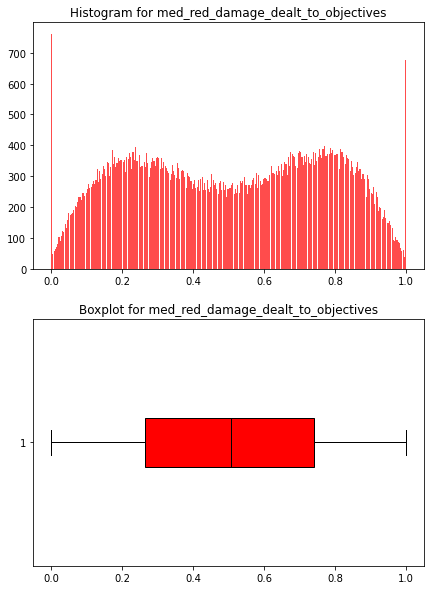

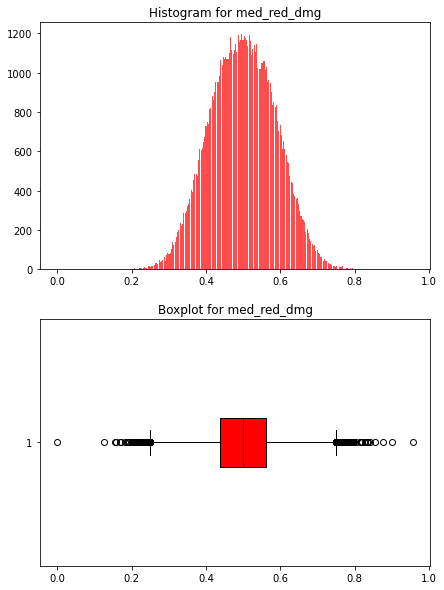

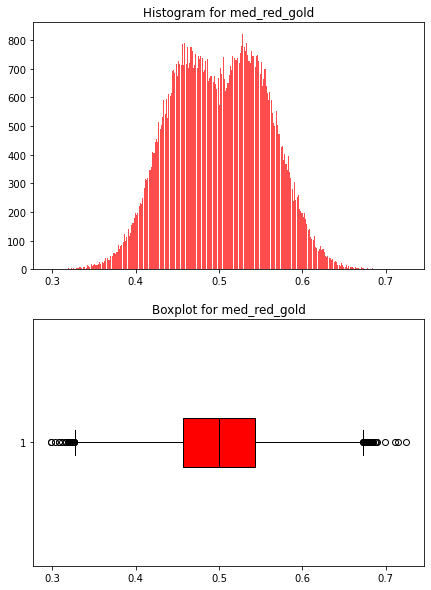

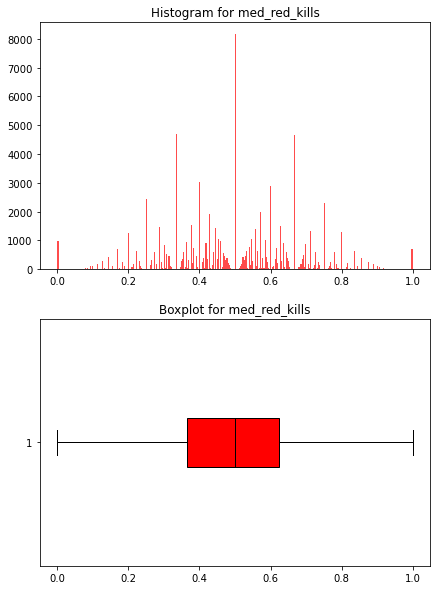

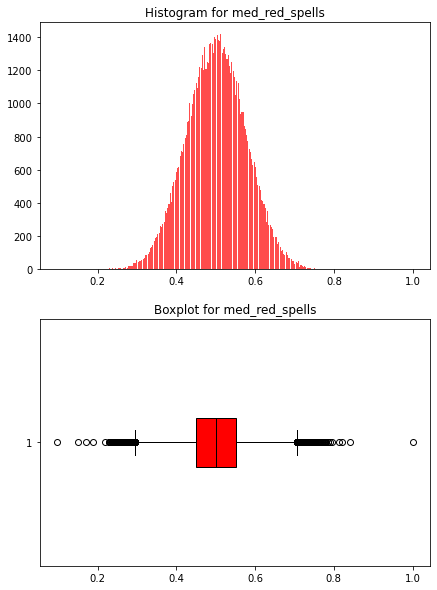

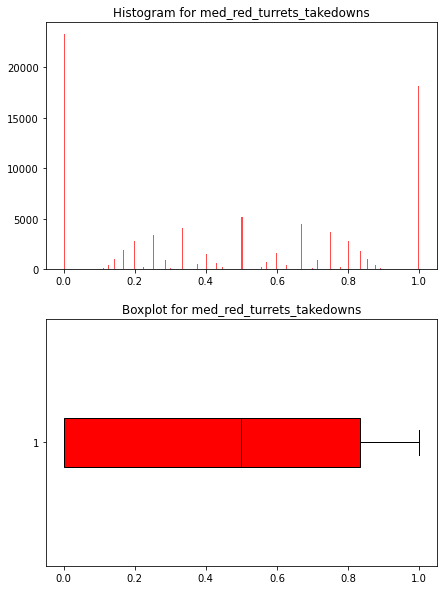

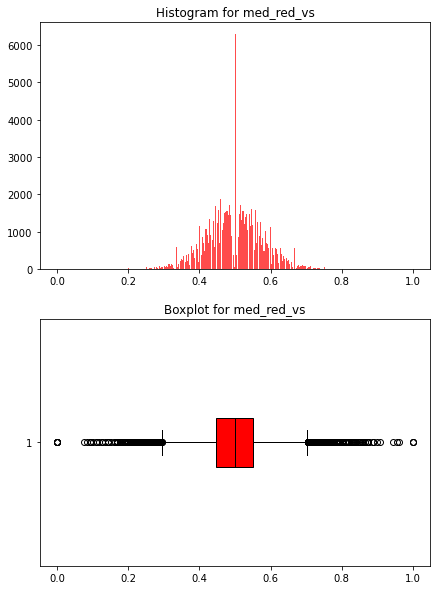

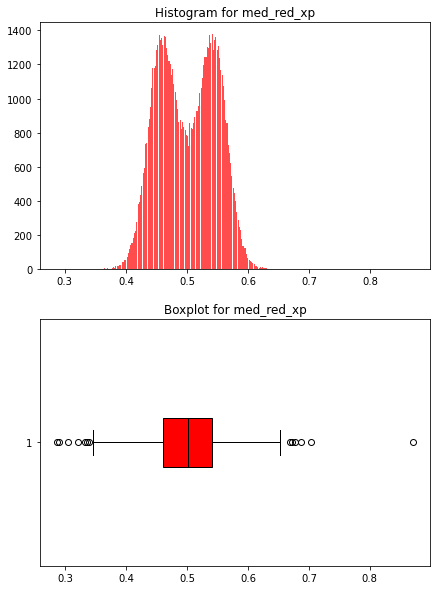

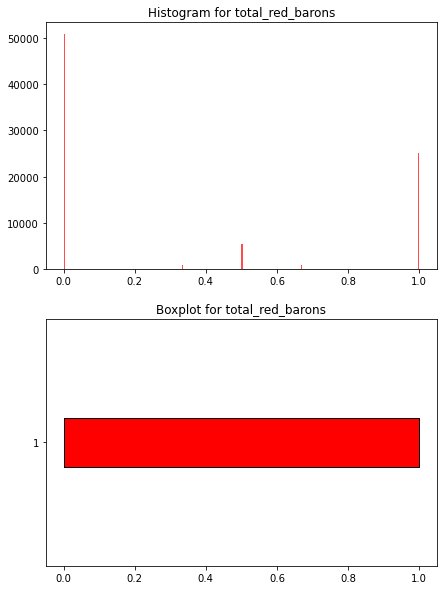

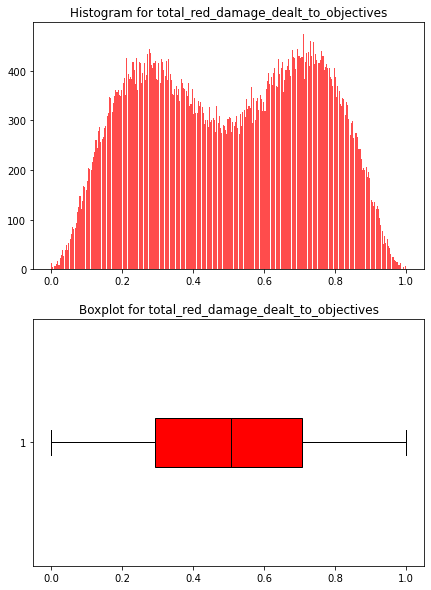

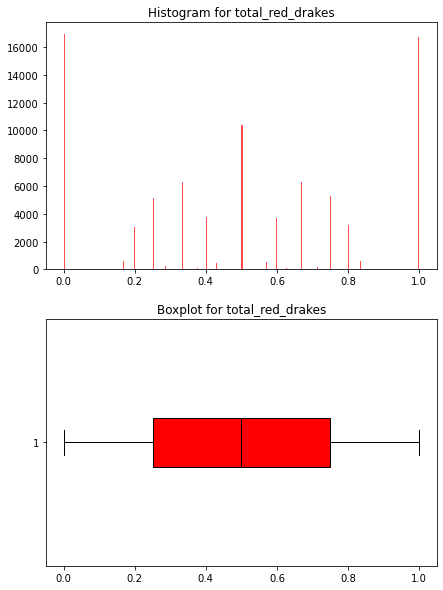

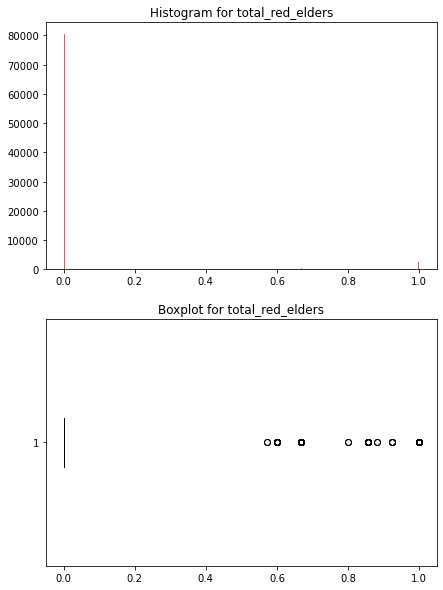

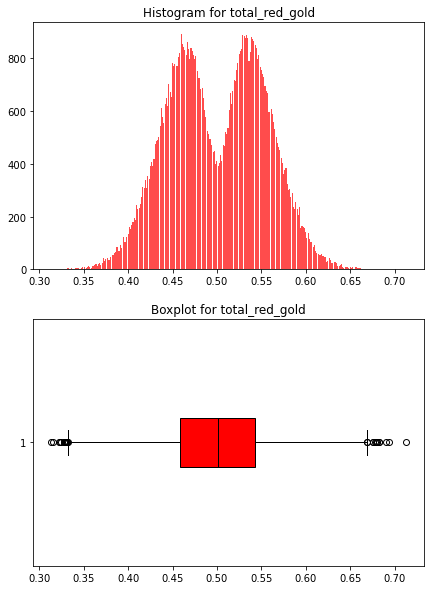

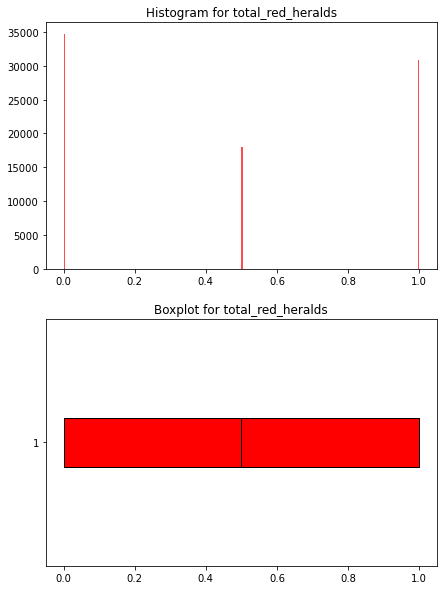

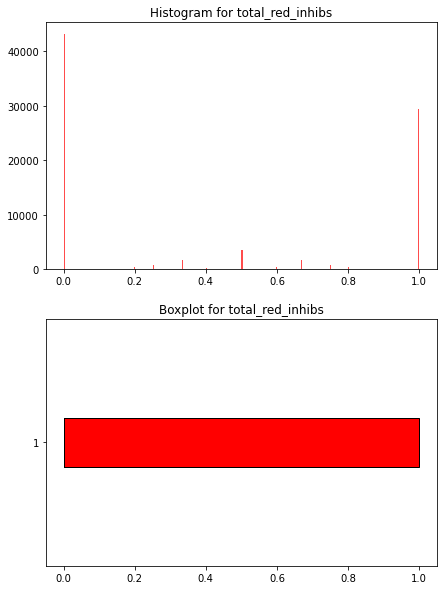

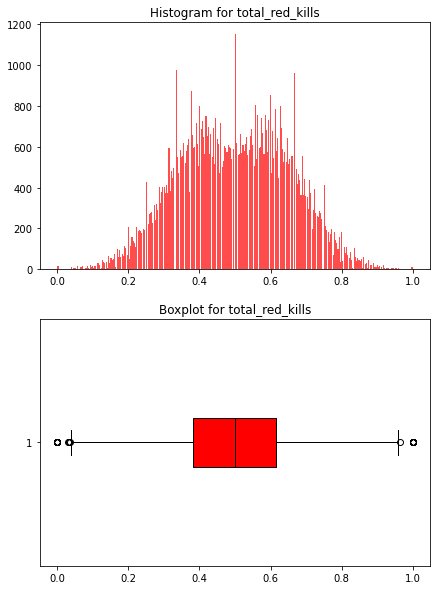

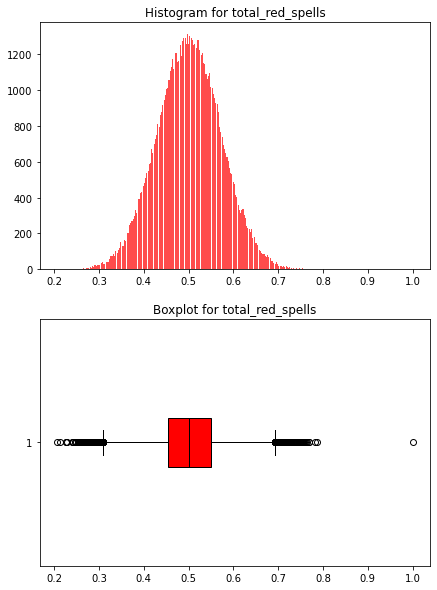

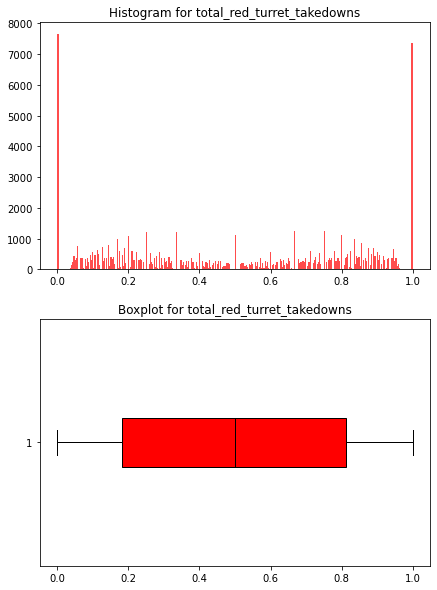

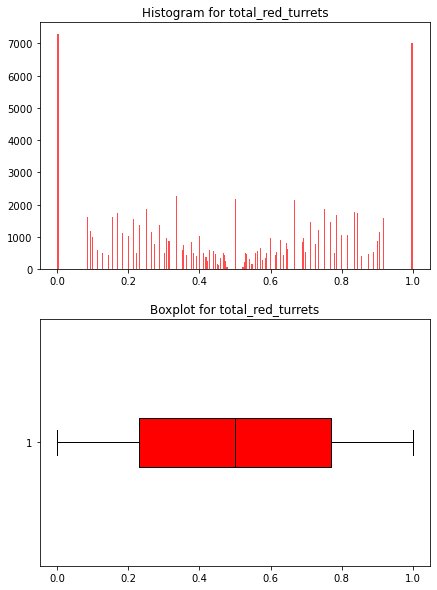

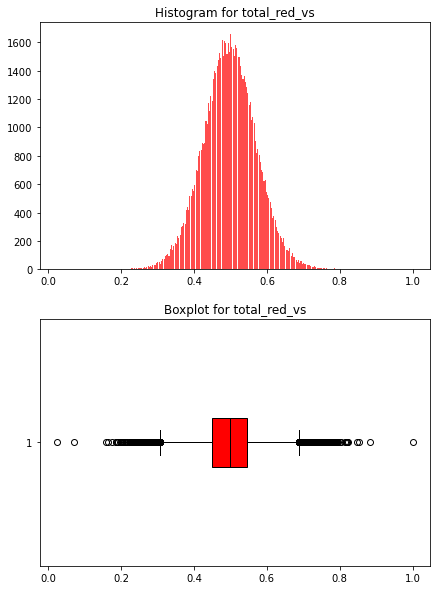

In [244]:
filtered_columns = [col for col in lol_df[filtered_columns] if 'red' in col.lower()]

for column in filtered_columns:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 10))

    ax1.hist(lol_df[column], bins=288, color='red', alpha=0.7, rwidth=0.85)
    ax1.set_title(f'Histogram for {column}')

    ax2.boxplot(lol_df[column], vert=False, widths=0.2, patch_artist=True,
                boxprops=dict(facecolor='red', color='black'), medianprops=dict(color='black'))
    ax2.set_title(f'Boxplot for {column}')

    plt.show()

Si observamos cada plot, podemos observar como hay gran presencia de outliers. Aun así, es normal tener presencia de dichos outliers, dada la naturalidad de las partidas de League of Legends. Con esto, nos referimos a la gran diversidad de maneras en las que una partida puede concluir: Desde un stomp en 12 minutos hasta una partida de 50 mins con 2 elders y 3 barones completados. Por ello, consideramos la presencia de outliers como válida. 

### - Clases

Como hemos mencionado al principio, nuestra variable objetivo va a ser winning_team (0 == blue win ; 1 == red win). Para ello, vamos a analizar dicha variable categórica y así determinar si nos es útil como variable objetivo

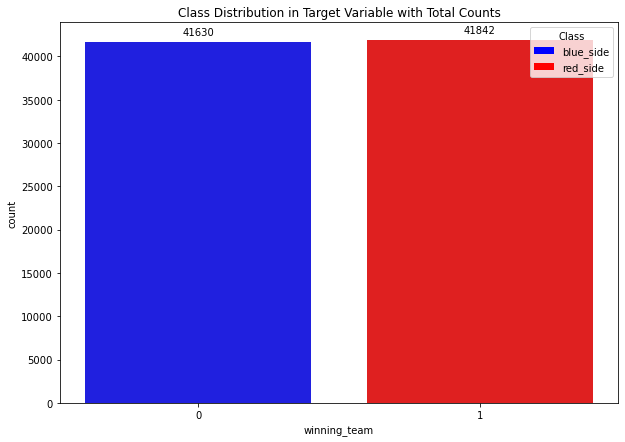

In [245]:
plt.figure(figsize=(10,7))
colors = {'blue_side': 'blue', 'red_side': 'red'}

ax = sns.countplot(x='winning_team', data=lol_df, palette=colors.values())

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

for label, color in colors.items():
    plt.bar(0, 0, label=label, color=color, linewidth=0)

plt.title('Class Distribution in Target Variable with Total Counts')
plt.legend(title='Class')
plt.show()

Para nuestra sorpresa, después del filtrado de observaciones, vemos como para este dataset el lado rojo tiene mejor winrate que el lado azul. Si ponemos en perspectiva este dataset con todas las partidas de lol jugadas en cada liga competitiva internacional jugada en los últimos tres años, no podemos afirmar que este dataset sea representativo del dato expuesto al principio. 

Dejando de lado esto, vemos como la cantidad de datos que tenemos de ambos lados está equilibrado, por lo que podemos proseguir con nuestro modelo sin miedo a tener un sesgo generado por un no equilibrio de datos entre clases.

Otro aspecto a considerar para determinar que nuestra variable objetivo es válida para el modelo es la correlación. Si observamos la correlación de dicha variable objetivo con las demás, vamos a tener una primera idea de si podemos explicar el winning_team a base de otras variables y predecir en cierta medida si el modelo de clasificación será exitoso.

<AxesSubplot:>

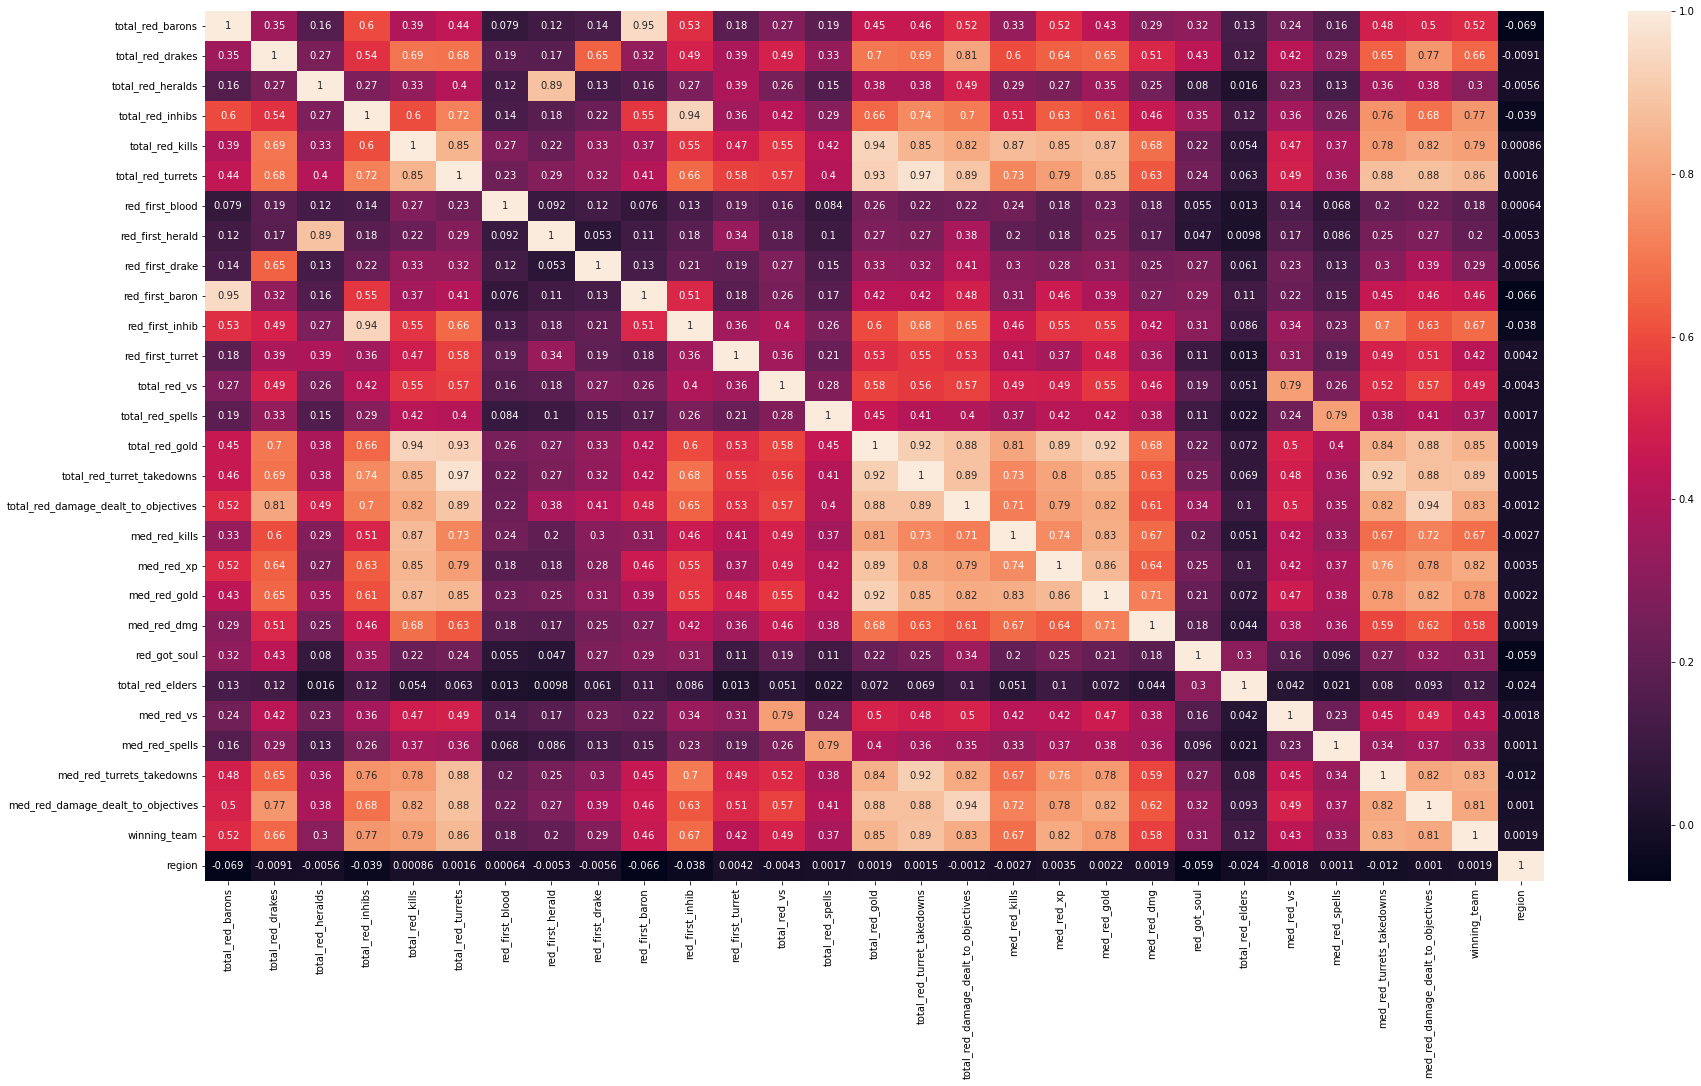

In [246]:
columns_of_interest = lol_df.filter(like='red').columns.tolist() + ['winning_team'] + ['region']
df_red = lol_df[columns_of_interest]

plt.figure(figsize = (30, 16))
sns.heatmap(df_red.corr(), annot = True)

Y efectivamente, podemos ver como hay la variable winning_team tiene muchas variables candidatas para explicarla, debido a la alta correlación presente. También comentar que, si observamos la variable región (otra variable candidata a ser objetivo), hay muy poca correlación entre todas las demás. Esto nos hace entender que, en elos altos, para las variables presentes en el estudio, no hay diferencia entre regiones. Eso no afirma que entre regiones no haya diferencia de nivel/conocimiento del juego. De hecho, lo hay. Solo hace falta mirar los Worlds de cada año y ver quien es la región dominante. Pero, para las variables que se han seleccionado, no hay diferencia entre regiones.

Como también veremos más adelante, podemos incluso llegar a pensar que lo que diferencia a las regiones va mucho más allá de las métricas presentes en los datasets, o que se requieren de métricas más complejas (pathings de la jungla, decisiones de macro game...).

### - Variables

Al ser una clasificación binaria, vamos a usar la Regresión Logística como modelo de clasificación. Para ello, requerimos de una disminución de las variables de entrada, para así asegurar que el modelo funcione lo mejor posible, sin riesgo a que se produzca un sobreajuste. 

Como criterio inicial para descartar variables, vamos a fijarnos en la correlación con la variable objetivo, quedándonos con las que tengan un 80% o más de relación.

In [247]:
high_corr = abs(df_red.corr()['winning_team']) >= 0.8

selected_columns = df_red.loc[:, high_corr].columns

df_selected = df_red[selected_columns]


categories = df_selected['winning_team'].unique()

lol_df_filt = pd.DataFrame()

for category in categories:
    category_data = df_selected[df_selected['winning_team'] == category]
    sampled_category_data = category_data.sample(n=2500, random_state=42)
    lol_df_filt = pd.concat([lol_df_filt, sampled_category_data], ignore_index=True)

print(lol_df_filt.shape)



(5000, 8)


Una vez hecho un primer filtrado, vamos a observar como se comportan dichas variables seleccionadas entre ellas. Cabe destacar que el modelo puede sobreajustarse si tiene múltiples entradas altamente correlacionadas. Consideremos calcular las correlaciones por pares entre todas las entradas y eliminar las entradas altamente correlacionadas. Cabe destacar que nos hemos quedado con 2500 observaciones de cada tipo (win lado rojo / win lado azul), para agilizar el tiempo de computación del pairplot, al igual que asegurar un no sobreajuste/overfitting de la regresión logística

Antes de realizar dicha eliminación, vamos a observar el comportamiento de estas:

 

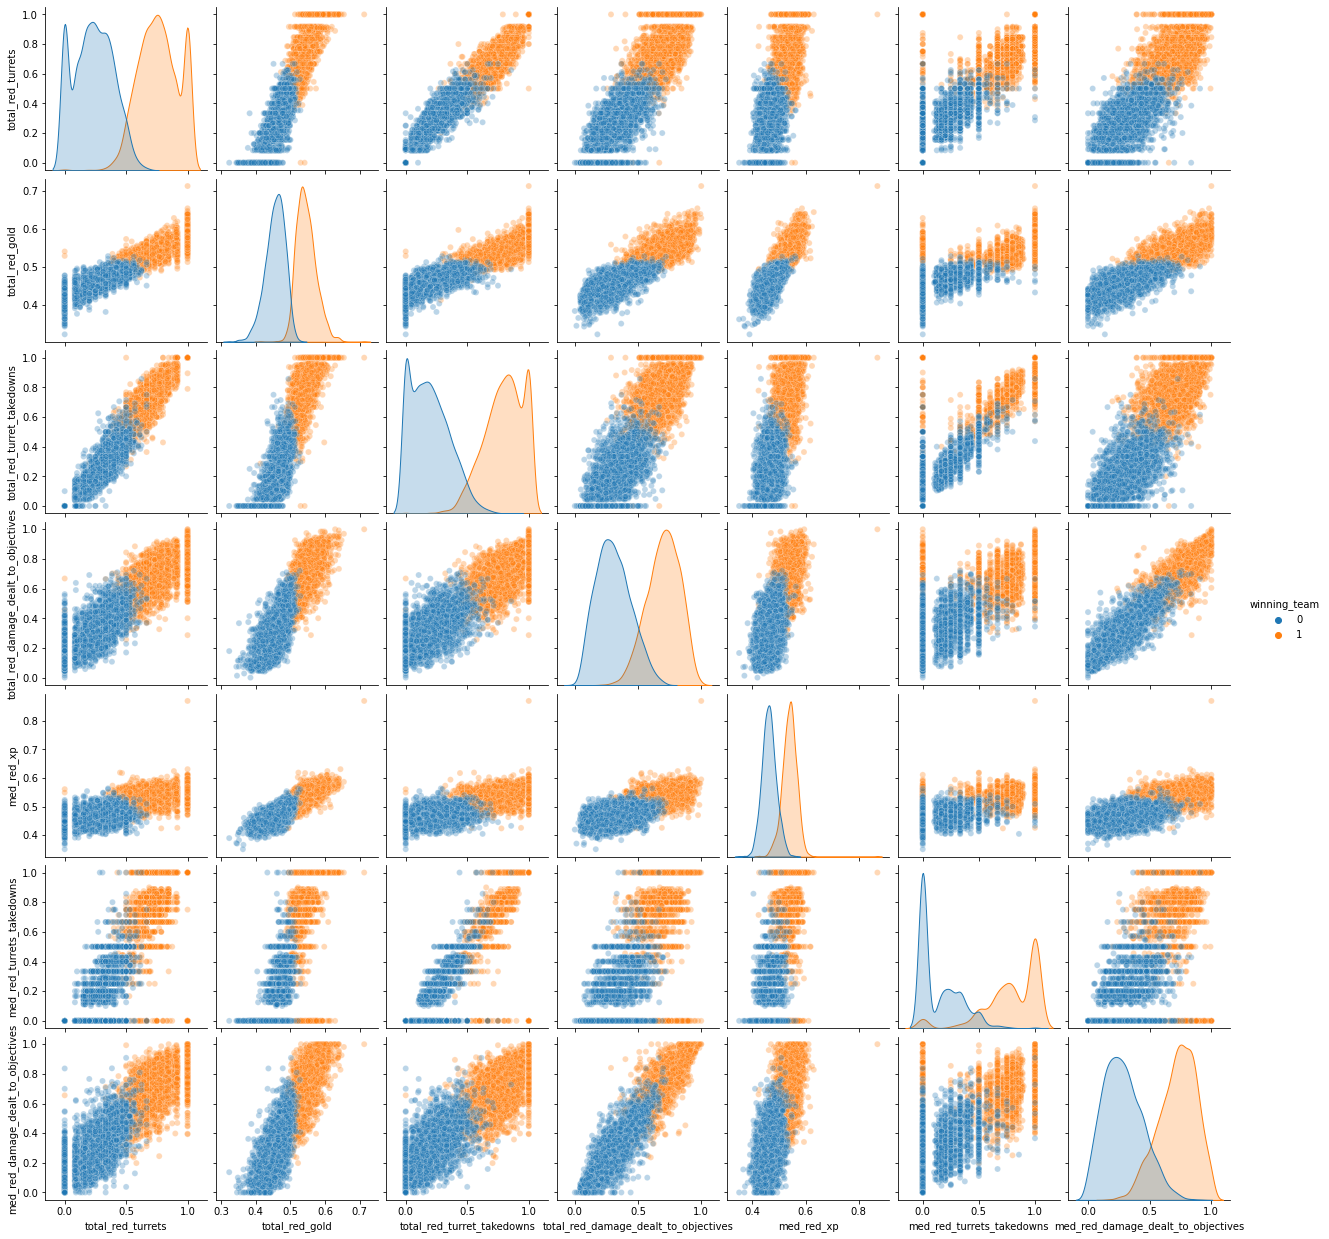

In [248]:
sns.pairplot(lol_df_filt, hue = 'winning_team', plot_kws={"alpha": 0.3})

Gracias al pairplot, podemos observar como hay una altra correlación entre algunas variables, los que nos puede alertar de un posible peligro para el modelo. Aun así, vamos a testear el modelo con las variables seleccionadas, y a partir de los resultados, ajustarlas

### - Conclusiones 

Con la limpieza de los datos y la exploración de estos, uno se da cuenta rápidamente que han sido unos datos ya tratados, es decir, normalizados y listos para ser usados en un modelo de predicción. Aun así, la presencia de nulos y duplicados ha ocurrido, pero sin ninguna implicación mayor a su eliminación. Por lo que hace a las clases, hemos identificado una clara candidata binaria (winning_team), y hemos observado cómo la variable region (3 clases), no nos va a permitir hacer un modelo multiclase satisfactorio, debido a su baja correlación con las demás variables. Hablando de variables, hemos realizado una reducción de la dimensionalidad, basándonos en la correlación. Gracias a ello, hemos reducido de 29 a 6. Sin embargo, hemos detectado una alta correlación general entre ellas, lo que puede afectar al modelo escogido.

Antes de sacar conclusiones erróneas, vamos a entrenar el modelo con las variables filtradas, y a partir de allí ajustarlas como sea necesario. No sorprendría si el modelo no ajusta correctamente, o incluso da una accuracy del 100%, dada la alta correlación entre las variables seleccionadas. Igualmente, si se trabajan las 6 variables, estoy seguro de que las clases podrán ser identificables.

### 2.2 Clasificación

Para este apartado, vamos a realizar una clasificación binaria. Usaremos la Regresión Logística y un Árbol de decisión.

#### Regresión Logística

Accuracy: 0.98

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1013
           1       0.98      0.98      0.98       987

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



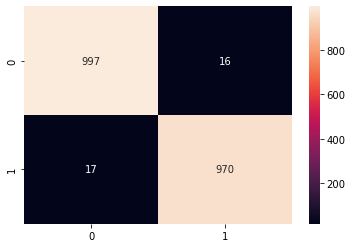

In [249]:
y = lol_df_filt.winning_team
lol_df_filt = lol_df_filt.drop('winning_team', axis=1)
X = lol_df_filt.values

scaler = StandardScaler()

X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=66)

model = LogisticRegression(random_state=66)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot = True,fmt='.0f')
print("\nClassification Report:")
print(classification_rep)

Dado los resultados de la regresión logística, podemos concluir que tenemos un modelo muy bueno de clasificación, en donde 98% de las predicciones realizadas son correctas en relación con el total de observaciones en el conjunto de datos. Por lo que podemos determinar en la matriz de confusión, no hay un lado (rojo o azul) en particular en el que el modelo se confunda más.

Dado el pairplot anterior en donde hemos observado una presencia de correlaciones entre algunas variables, vamos a indagar más en ello, haciendo un filtrado de las que están más correlacionadas entre ellas.

Esto no solo tiene sentido para prevenir un modelo mal entrenado (con sobreajuste), sino que también nos ahorra tiempo de computación. Si una variable se puede explicar en gran parte con otra, podemos directamente solo usar una de las dos.

<AxesSubplot:>

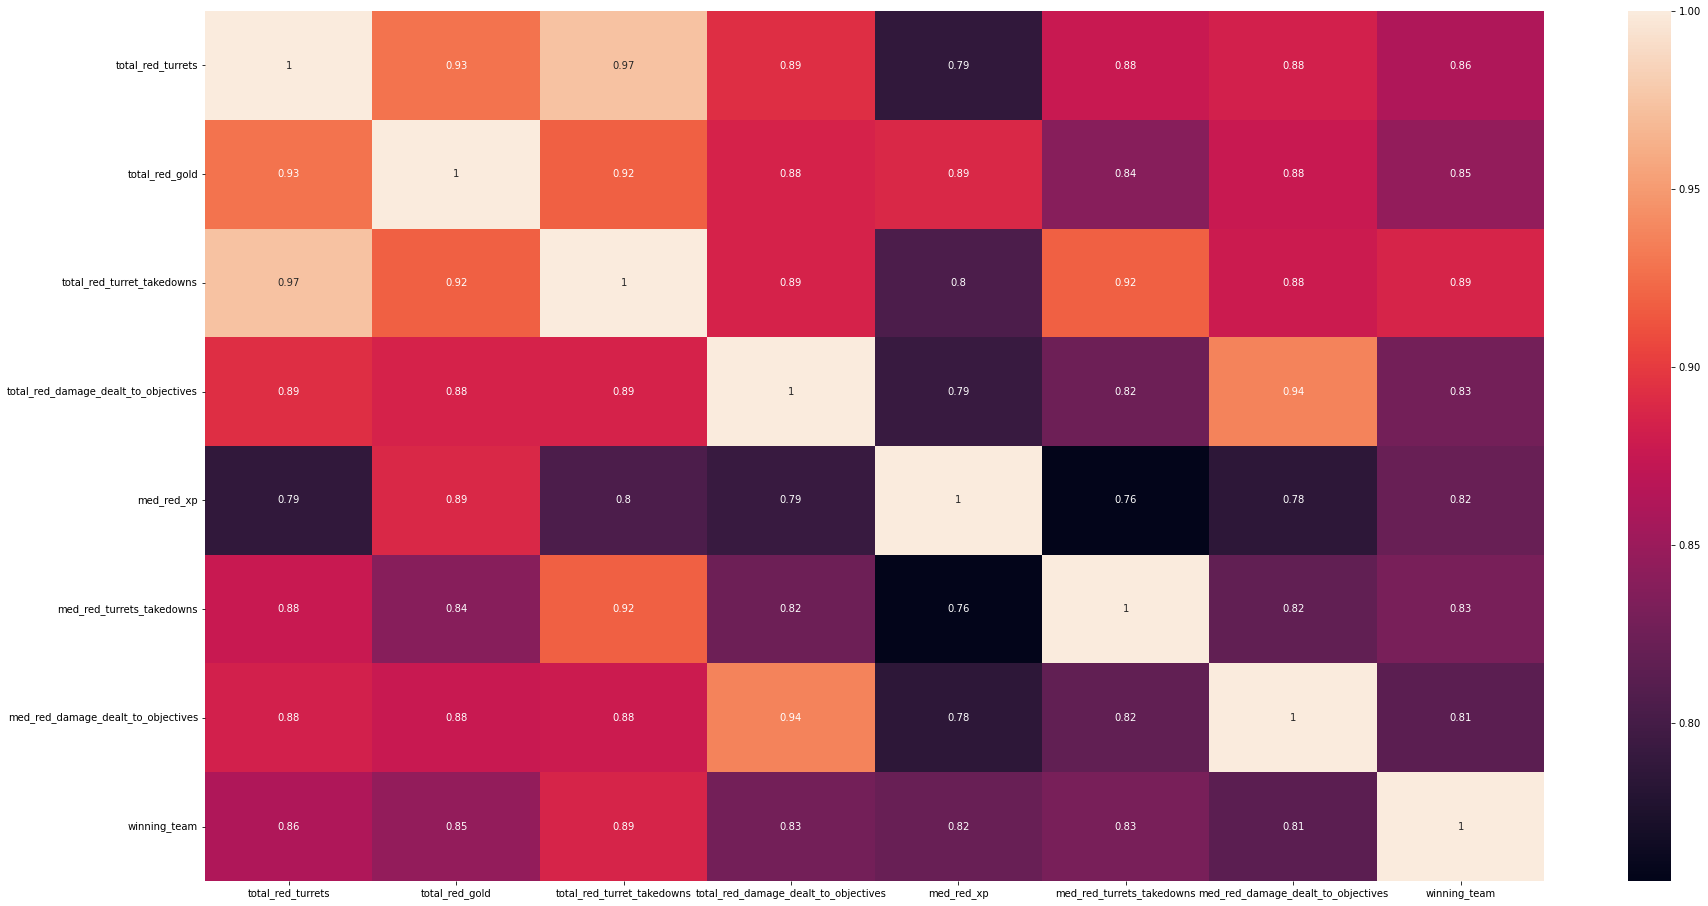

In [250]:
high_corr = abs(df_red.corr()['winning_team']) >= 0.8

selected_columns = df_red.loc[:, high_corr].columns

df_selected = df_red[selected_columns]


plt.figure(figsize = (30, 16))
sns.heatmap(df_selected.corr(), annot = True)

Efectivamente, podemos ver como hay una gran correlación entre variables candidatas. Para descartarlas, podemos ir una por una y escoger entre las que no tienen correlación alta entre ellas. Al ser un proceso manual y, en este caso, con pocas variables, puede ser una metodología viable. Aun así, a modo de práctica, vamos a realizar una PCA para tener un criterio más firme, y contrastarlo con un árbol de decisión. 

De hecho, haremos 2 PCA. Una con los datos ya filtrados y otra con todos los datos del lado rojo. La primera PCA nos permetrá ver que la pasa al modelo de regresión logística si le entramos menos variables + qué variables son las más significativas. La segunda PCA nos permite ver, de entre todas las variables del lado rojo, cuáles explican la variabilidad total del conjunto de datos. Además, aprovecharemos el árbol de decisión para no tan solo comprobar los resultados de la PCA, sino para evaluar su rendimiento como modelo de clasificación


#### - PCA 1: Red side filtrado 

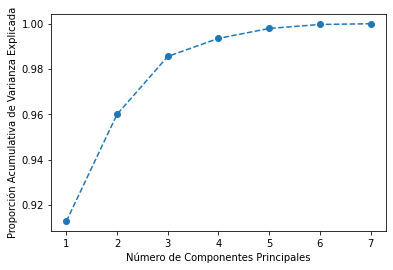

PC1: Columna: med_red_turrets_takedowns, Valor: 0.5479121262116629
PC2: Columna: med_red_turrets_takedowns, Valor: 0.7269012266918016
PC3: Columna: total_red_turrets, Valor: 0.5653033026008338
PC4: Columna: total_red_damage_dealt_to_objectives, Valor: 0.7832969354046414
PC5: Columna: total_red_turret_takedowns, Valor: 0.7195593985391096
PC6: Columna: med_red_xp, Valor: 0.8606280156538485
PC7: Columna: total_red_gold, Valor: 0.8641264081271851


In [251]:

X = df_selected.iloc[:, :-1].values
y = df_selected['winning_team']

pca = PCA()
X_pca = pca.fit_transform(X)

explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance_ratio = explained_variance_ratio.cumsum()
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Proporción Acumulativa de Varianza Explicada')
plt.show()

n_components_to_keep = 7

df_pca = pd.DataFrame(
    data    = pca.components_,
    columns = df_selected.iloc[:, :-1].columns,
    index   = [f'PC{i+1}' for i in range(n_components_to_keep)]
)

df_pca_abs = df_pca.abs()
max_abs_values = df_pca_abs.apply(lambda row: row.sort_values(ascending=False).iloc[0], axis=1)
max_abs_columns = df_pca_abs.apply(lambda row: row.sort_values(ascending=False).idxmax(), axis=1)


for i, column in enumerate(df_pca.columns):
    print(f'PC{i+1}: Columna: {max_abs_columns.iloc[i]}, Valor: {max_abs_values.iloc[i]}')


Para la primera PCA, con tan solo 2 componentes podemos explicar gran parte de la variabilidad de los datos. Para ello, vamos a volver a lanzar una regresión logística, pero esta vez con tan solo la variable med_red_turrets_takedowns (ya que es la variable que esta mayor explica la variabilidad en las 2 componentes principales escogidas)

Accuracy: 0.93

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     16639
           1       0.92      0.93      0.93     16750

    accuracy                           0.93     33389
   macro avg       0.93      0.93      0.93     33389
weighted avg       0.93      0.93      0.93     33389



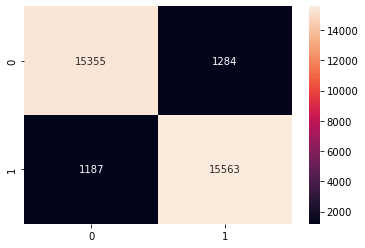

In [252]:

X = df_selected['med_red_turrets_takedowns'].values.reshape(-1, 1)

y = df_selected['winning_team']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=66)

model = LogisticRegression(random_state=66)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot=True, fmt='.0f')
print("\nClassification Report:")
print(classification_rep)

Y efectivamente, con tan solo una variable, obtenemos un modelo con un 93% de precisión, por lo que podemos anotar que derribar torretas es un buen comienzo para ganar

#### - PCA 2: Red side completo

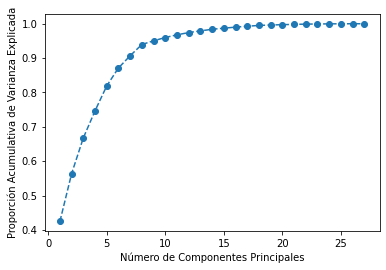

PC1: Columna: red_first_inhib, Valor: 0.36107031391384864
PC2: Columna: red_first_herald, Valor: 0.5995012115015911
PC3: Columna: red_first_drake, Valor: 0.5811620982199706
PC4: Columna: red_first_blood, Valor: 0.8270529535614451
PC5: Columna: red_first_drake, Valor: 0.4199712326390219
PC6: Columna: red_first_turret, Valor: 0.7261895253082692
PC7: Columna: red_got_soul, Valor: 0.6611179690532603
PC8: Columna: red_got_soul, Valor: 0.6177125802356576
PC9: Columna: total_red_drakes, Valor: 0.67324812690412
PC10: Columna: total_red_elders, Valor: 0.9466825346315487
PC11: Columna: total_red_heralds, Valor: 0.740825126391535
PC12: Columna: med_red_kills, Valor: 0.5465502190941687
PC13: Columna: med_red_kills, Valor: 0.5837398589239289
PC14: Columna: total_red_inhibs, Valor: 0.6326584234309255
PC15: Columna: med_red_damage_dealt_to_objectives, Valor: 0.5839969707515954
PC16: Columna: total_red_barons, Valor: 0.5521991458369939
PC17: Columna: med_red_spells, Valor: 0.6667100854003278
PC18: Col

In [253]:
X = df_red.iloc[:, :-2].values
y = df_red['winning_team']

pca = PCA()
X_pca = pca.fit_transform(X)

explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance_ratio = explained_variance_ratio.cumsum()
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Proporción Acumulativa de Varianza Explicada')
plt.show()

n_components_to_keep = 27

df_pca = pd.DataFrame(
    data    = pca.components_,
    columns = df_red.iloc[:, :-2].columns,
    index   = [f'PC{i+1}' for i in range(n_components_to_keep)]
)

df_pca_abs = df_pca.abs()
max_abs_values = df_pca_abs.apply(lambda row: row.sort_values(ascending=False).iloc[0], axis=1)
max_abs_columns = df_pca_abs.apply(lambda row: row.sort_values(ascending=False).idxmax(), axis=1)


for i, column in enumerate(df_pca.columns):
    print(f'PC{i+1}: Columna: {max_abs_columns.iloc[i]}, Valor: {max_abs_values.iloc[i]}')

Para esta segunda PCA, hemos considerado todos los datos de la red side. Tal y como podemos observar, con 7 componentes podemos explicar gran parte de la varianza de los datos. De entr las 7 componentes, destacan las siguientes variables:

- PC1: red_first_inhib, Valor: 0.36107031391384864
- PC2: red_first_herald, Valor: 0.5995012115015911
- PC3: red_first_drake, Valor: 0.5811620982199706
- PC4: red_first_blood, Valor: 0.8270529535614451
- PC5: red_first_drake, Valor: 0.4199712326390219
- PC6: red_first_turret, Valor: 0.7261895253082692
- PC7: red_got_soul, Valor: 0.6611179690532603

Ahora, vamos a realizar un Árbol de decisión, para contrastar estas variables con el resultado del modelo.

-------

#### Árbol de decisión (binario)

In [254]:
target_column = 'winning_team'

columns_except_target = [col for col in df_red.columns if col != target_column]

df_red = df_red[columns_except_target + [target_column]]

X = df_red.iloc[:, :-1]
df_c = df_red

for column in X.columns:
    if df_red[column].dtypes == object:
        df_c[column] = df_red[column].astype("category").cat.codes



In [255]:
X = df_c.iloc[:, :-1].values
y = df_c.iloc[:, -1].values

In [256]:
scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=62)

model_params={
    'max_leaf_nodes':[50,100,500,5000],
    'min_samples_split':[2,4,6]
}

model = DecisionTreeClassifier(random_state=26)
gscv = GridSearchCV(model, model_params, cv =3)
model_gs = gscv.fit(X_train, y_train)
print("Best: %f using %s" % (model_gs.best_score_,model_gs.best_params_))


Best: 0.982224 using {'max_leaf_nodes': 50, 'min_samples_split': 2}


Accuracy: 0.98

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8298
           1       0.98      0.98      0.98      8397

    accuracy                           0.98     16695
   macro avg       0.98      0.98      0.98     16695
weighted avg       0.98      0.98      0.98     16695



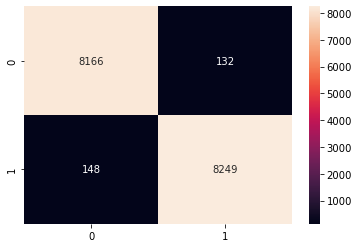

In [257]:
model = DecisionTreeClassifier(max_leaf_nodes=50, min_samples_split=2, criterion='entropy')
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot=True, fmt='.0f')
print("\nClassification Report:")
print(classification_rep)

Nuevamente, usando un Árbol de decisión obtenemos un muy buen modelo, en donde el 98% de las veces la predicción acierta. Dicho esto, vamos a ver cuales han sido las variables más importantes para éste árbol de decisión:

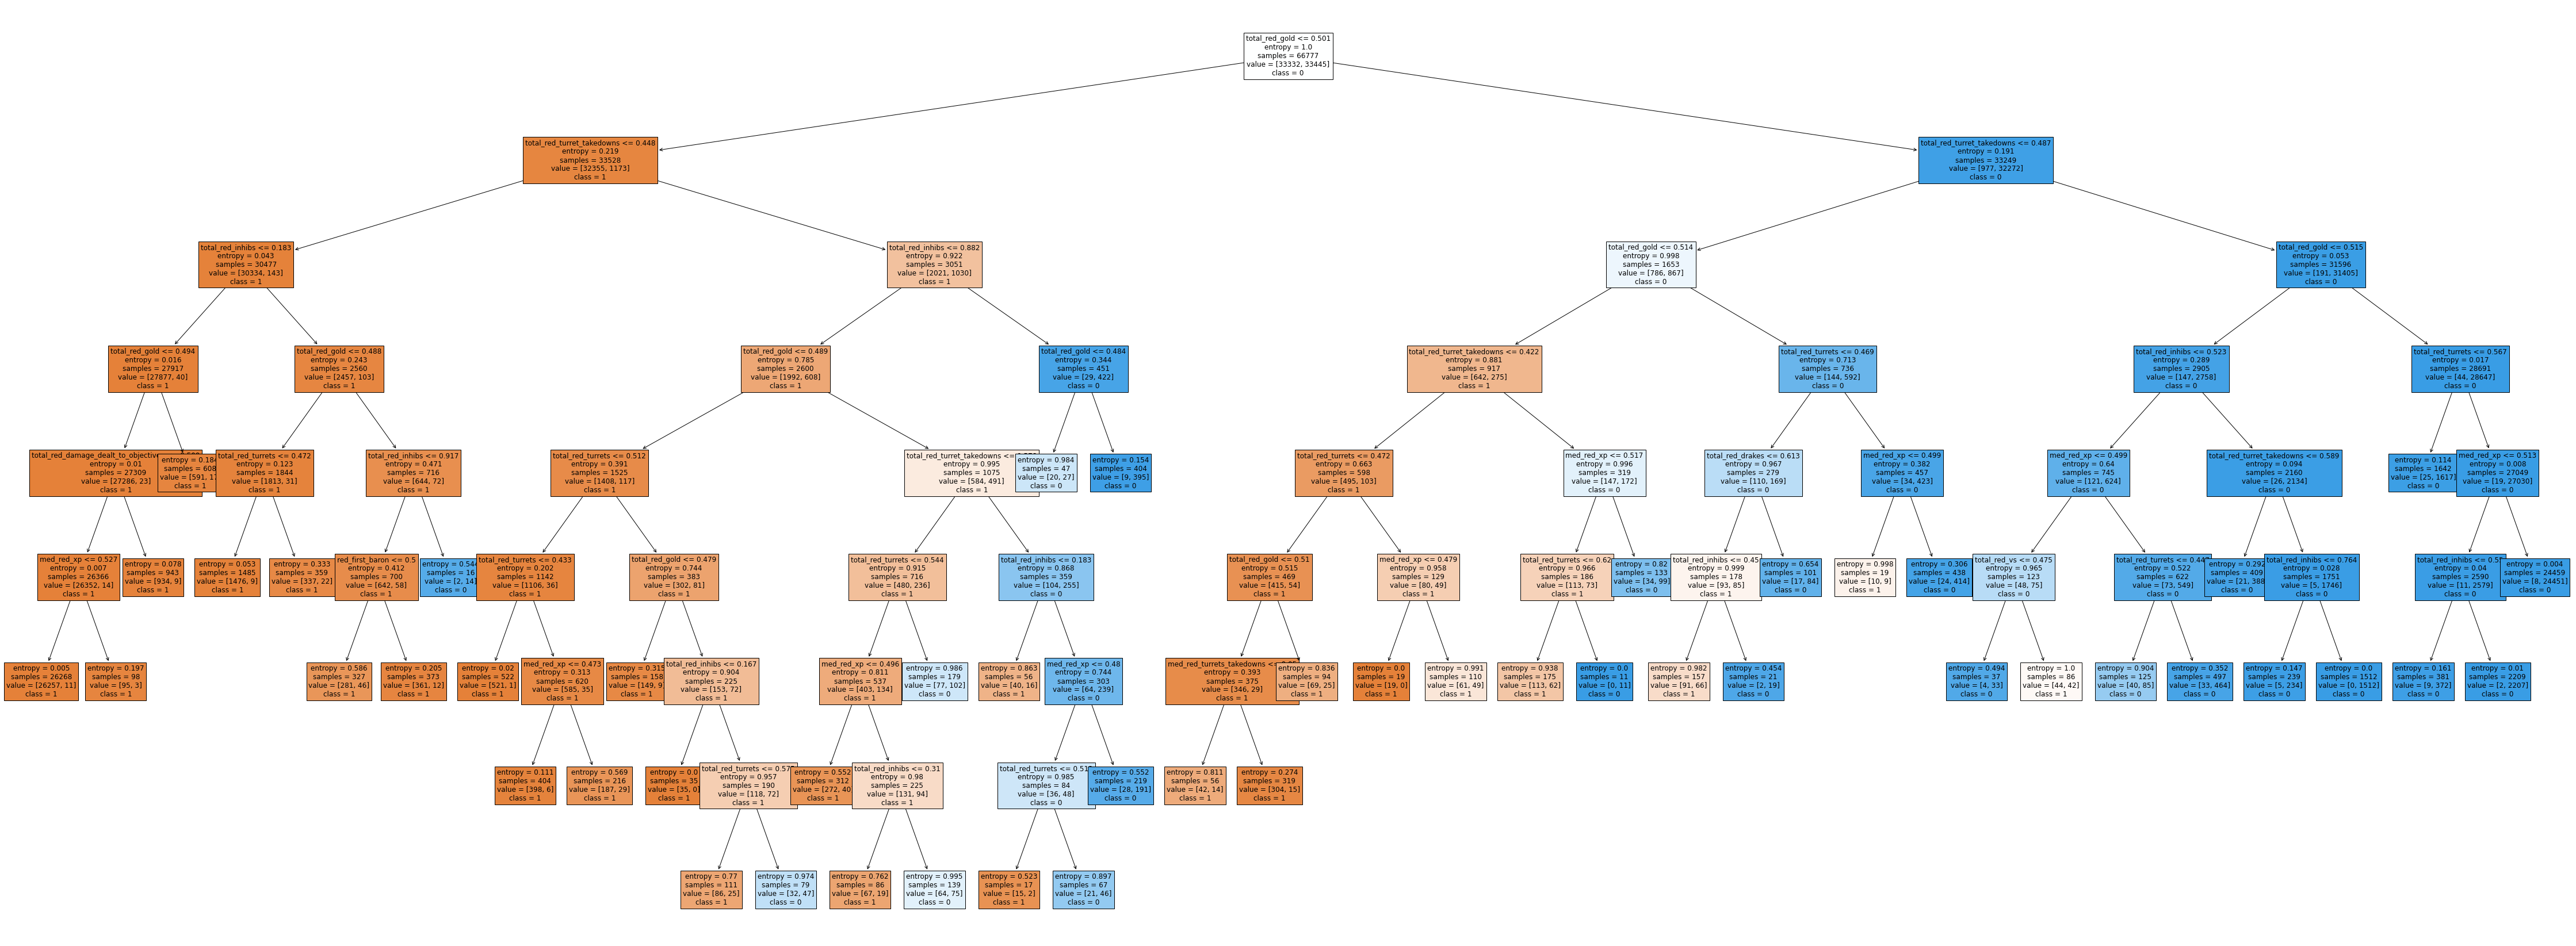

In [258]:
fig = plt.figure(figsize=(80,30))
_ = tree.plot_tree(model, 
                   feature_names=df_c.columns[:-1],  
                   class_names=df_c['winning_team'].unique().astype(str),
                   filled=True,
                   fontsize=12)

En este caso, la variable más relevante ha estado total_red_gold, seguido de la que hemos anotado antes, turret_takedowns. De hecho, si seguimos explorando el árbol, podemos afirmar que las variables que determinan el ganar una partida són, por orden:

- Oro generado
- Estructuras (torretas e inhibidores)
- Experiencia de los campeones (nivel)
- Dragones totales




#### - Observaciones 

Una vez hemos visto las características de nuestros datos, juntamente con el resultado de los entrenamientos en ambos modelos (Regresión Logística y Árbol de decisión), vamos a reflexionar sobre cuál es el indicado para el caso que nos ocupa. Para ello, vamos a recalcar que ventajas e inconvenientes hemos observado durante el desarrollo de los algoritmos:

- Regresión Logística:

La interpretación de los resultados es prácticamente instantánea, al tratarse de probabilidad de pertenecer a una clase o no. Aun así, este método requiere de un tratado del dato exhaustivo con anterioridad, ya que es sumamente sensible a la multicolinealidad. Dicho de otra forma, se requiere de un preprocesado para escoger las variables más importantes, asegurando no colinealidad entre ellas.

Es por ello que, con las 6 variables (con un alto grado de multicolinealidad), nos ha dado un modelo muy bueno, pero que carece de confianza. Aun así, con un análisis más profundo, hemos podido obtener un modelo muy bueno con tan solo una variable, lo que, a priori, pone como favorito a este método. Cierto es que este método se ha visto beneficiado por la alta linealidad en nuestros datos (hemos podido observar en el pairplot como la mayoría de relaciones eran de carácter lineal, y no seguían patrones no lineales complejos).

- Árbol de Decisión:

Por otro lado, para el árbol de decisión no se ha requerido ningún preprocesado ni filtrado de datos (es capaz de ignorar las variables irrelevantes). Aunque sean más propensos a tener sobreajuste, hemos podido presenciar como en los datos no vistos, el modelo se ha comportado de manera satisfactoria. Además, tal y como hemos visto, tenemos un balance de datos entre clases, lo que beneficia mucho a los árboles de decisión.

No contentos con ello, este método nos ha dado información más relevante para el objetivo de esta entrega que la regresión lineal, señalando las variables importantes, junto con el orden de importancia de estas. Cierto es que su interpretabilidad es algo compleja, pero dado que es una clasificación binaria, el árbol no ha salido del todo extenso, lo que no empeora su interpretación. Además, ha salido la misma accuracy que en la regresión logística

En definitiva, dado el objetivo de la entrega (encontrar una estrategia para que el lado rojo pueda ganar más), el árbol de decisión nos puede resultar más útil.

-----------

## 2.3 Optativo

Para el apartado optativo, como primera idea, se pretendía clasificar los jugadores por región. Visto el éxito de dicha variable en la matriz de correlación, se ha optado por intentar clasificar los distintos campeones por role (top,jungle,mid,bottom,support). Para ello, se ha requerido el preprocesado de los .json, es decir, no se ha usado el dataset ya preparado que se proporciona. Para ello, nuevamente, nos hemos inspirado en el código proporcionado por los creadores del datset [1], pero esta vez, sacando información a nivel de player y no a nivel team.

In [259]:
'''
    Takes the JSON files for the matches' data, extracts the relevant features and saves
    all of it in tabular form
'''




np.seterr(divide='ignore', invalid='ignore')
start = time.time()
total_matches = 0

dirname = './collected_data'
 
ext = '.json'

final_filename = "./data_champs.csv"

to_save = []
 
for file in os.listdir(dirname):
    total_matches = 0
    if file.endswith(ext) and '_matches_' in file:
        with open(os.path.join(dirname,file), "r") as jfile:

            data = json.load(jfile)
            data = data["match_data"]
            max_matches_to_save = 10

            if m["platformId"] == "EUW1":
                region = 0
            elif m["platformId"] == "NA1":
                region = 1
            else:
                region = 2

            print(f">> Working through the data in: {file} <<")

            for m in tqdm(data):

                if m["gameMode"] != 'CLASSIC':
                    continue
                else:
                    # updated running game count
                    total_matches += 1

                    game_duration = m["gameDuration"]

                    # loop through players to add above data
                    for p in m["participants"]:
                        assists = p["assists"]
                        baronKills = p["baronKills"]
                        champ_experience = p["champExperience"]
                        champ_level = p["champLevel"]
                        champion_id = p["championId"]
                        champion_name = p["championName"]
                        challenges_list = p.get("challenges", {})
                        skills_dodge = challenges_list.get("skillshotsDodged",0)
                        skills_hit = challenges_list.get("skillshotsHit",0)
                        ability_uses = challenges_list.get("abilityUses",0)
                        early_dragon = challenges_list.get("earliestDragonTakedown",0)
                        kill_part = challenges_list.get("killParticipation",0)
                        heralds = challenges_list.get("riftHeraldTakedowns",0)
                        damage_dealt_to_buildings = p["damageDealtToBuildings"]
                        damage_dealt_to_objectives = p["damageDealtToObjectives"]
                        damage_dealt_to_turrets = p["damageDealtToTurrets"]
                        damage_self_mitigated = p["damageSelfMitigated"]
                        deaths = p["deaths"]
                        gold_earned = p["goldEarned"]
                        gold_spent = p["goldSpent"]
                        individual_position = p["individualPosition"]
                        kills = p["kills"]
                        largest_critical_strike = p["largestCriticalStrike"]
                        largest_killing_spree = p["largestKillingSpree"]
                        largest_multi_kill = p["largestMultiKill"]
                        magic_damage_dealt = p["magicDamageDealt"]
                        magic_damage_dealt_to_champions = p["magicDamageDealtToChampions"]
                        magic_damage_taken = p["magicDamageTaken"]
                        neutral_minions_killed = p["neutralMinionsKilled"]
                        nexus_kills = p["nexusKills"]
                        objectives_stolen = p["objectivesStolen"]
                        objectives_stolen_assists = p["objectivesStolenAssists"]
                        physical_damage_dealt = p["physicalDamageDealt"]
                        physical_damage_dealt_to_champions = p["physicalDamageDealtToChampions"]
                        physical_damage_taken = p["physicalDamageTaken"]
                        spell1_casts = p["spell1Casts"]
                        spell2_casts = p["spell2Casts"]
                        spell3_casts = p["spell3Casts"]
                        spell4_casts = p["spell4Casts"]
                        summoner1_casts = p["summoner1Casts"]
                        summoner2_casts = p["summoner2Casts"]
                        total_damage_dealt = p["totalDamageDealt"]
                        total_damage_dealt_to_champions = p["totalDamageDealtToChampions"]
                        total_damage_shielded_on_teammates = p["totalDamageShieldedOnTeammates"]
                        total_damage_taken = p["totalDamageTaken"]
                        total_heal = p["totalHeal"]
                        total_heals_on_teammates = p["totalHealsOnTeammates"]
                        total_minions_killed = p["totalMinionsKilled"]
                        total_time_cc_dealt = p["totalTimeCCDealt"]
                        total_time_spent_dead = p["totalTimeSpentDead"]
                        total_units_healed = p["totalUnitsHealed"]
                        turret_takedowns = p["turretTakedowns"]
                        vision_score = p["visionScore"]
                        vision_wards_bought_in_game = p["visionWardsBoughtInGame"]
                        wards_killed = p["wardsKilled"]
                        wards_placed = p["wardsPlaced"]
                        win = p["win"]

                        row = [region,game_duration, assists, baronKills, champ_experience, champ_level, champion_id, champion_name,
                                skills_dodge,skills_hit,ability_uses,early_dragon,kill_part,heralds,
                                damage_dealt_to_buildings, damage_dealt_to_objectives, damage_dealt_to_turrets,
                                damage_self_mitigated, deaths, gold_earned, gold_spent, individual_position,
                                kills, largest_critical_strike,
                                largest_killing_spree, largest_multi_kill, magic_damage_dealt, magic_damage_dealt_to_champions,
                                magic_damage_taken, neutral_minions_killed, nexus_kills, objectives_stolen, objectives_stolen_assists,
                                physical_damage_dealt, physical_damage_dealt_to_champions, physical_damage_taken,
                                spell1_casts, spell2_casts, spell3_casts, spell4_casts,
                                summoner1_casts, summoner2_casts, total_damage_dealt, total_damage_dealt_to_champions,
                                total_damage_shielded_on_teammates, total_damage_taken, total_heal, total_heals_on_teammates,
                                total_minions_killed, total_time_cc_dealt, total_time_spent_dead, total_units_healed,
                                turret_takedowns, vision_score, vision_wards_bought_in_game, wards_killed,
                                wards_placed, win]

                        to_save.append(row)

                    if total_matches >= max_matches_to_save:
                        break


                    

            with open('df_list.pkl', 'wb') as f:  
                pickle.dump([to_save], f)

print(">> Going to save data to DataFrame <<")
cols = [
    "region","game_duration", "assists", "baronKills", "champ_experience", "champ_level", "champion_id",
    "champion_name","skills_dodge","skills_hit","ability_uses","early_dragon","kill_part","heralds",
    "damage_dealt_to_buildings", "damage_dealt_to_objectives", "damage_dealt_to_turrets",
    "damage_self_mitigated", "deaths", "gold_earned", "gold_spent", "individual_position",
    "kills", "largest_critical_strike",
    "largest_killing_spree", "largest_multi_kill", "magic_damage_dealt", "magic_damage_dealt_to_champions",
    "magic_damage_taken", "neutral_minions_killed", "nexus_kills", "objectives_stolen", "objectives_stolen_assists",
    "physical_damage_dealt", "physical_damage_dealt_to_champions", "physical_damage_taken",
    "spell1_casts", "spell2_casts", "spell3_casts", "spell4_casts",
    "summoner1_casts", "summoner2_casts", "total_damage_dealt", "total_damage_dealt_to_champions",
    "total_damage_shielded_on_teammates", "total_damage_taken", "total_heal", "total_heals_on_teammates",
    "total_minions_killed", "total_time_cc_dealt", "total_time_spent_dead", "total_units_healed",
    "turret_takedowns", "vision_score", "vision_wards_bought_in_game", "wards_killed", "wards_placed", "win"
]

lol_df = pd.DataFrame(to_save, columns=cols)


print(">> Exporting DataFrame to file <<")
lol_df.to_csv(final_filename, index=False)

print(f"=== Done in {time.time()-start} seconds ===")
print(f"\t\t*** Processed a TOTAL of {total_matches} matches ***")
                

>> Working through the data in: asia_matches_1.json <<


  0%|          | 11/30650 [00:00<00:01, 16495.30it/s]


>> Working through the data in: americas_matches_1.json <<


  0%|          | 10/46223 [00:00<00:03, 15109.16it/s]


>> Working through the data in: europe_matches_1.json <<


  0%|          | 9/20438 [00:00<00:01, 13530.01it/s]

>> Going to save data to DataFrame <<
>> Exporting DataFrame to file <<
=== Done in 94.49763464927673 seconds ===
		*** Processed a TOTAL of 10 matches ***


Dada la gran cantidad de variables seleccionadas (nuevamente, con el criterio adquirido gracias al gran conocimiento del dominio por mi parte (hardstucked in bronze)), se ha dado un nombre suficientemente explicativo a las variables para poder comprenderlas. Tal y como hemos visto en el anterior apartado, los datos han sido previamente tratados, por lo que podemos asegurar que no encontraremos valores fuera de lugar. 

Visto que contamos con una gran cantidad de variables, juntamente con los resultados favorables obtenidos en el anterior apartado, vamos a intentar realizar un Árbol de decisión sin un filtrado de datos prévio

In [260]:
target_column = 'individual_position'

columns_except_target = [col for col in lol_df.columns if col != target_column]

lol_df = lol_df[columns_except_target + [target_column]]

X = lol_df.iloc[:, :-1]
df_c = lol_df

for column in X.columns:
    if lol_df[column].dtypes == object:
        df_c[column] = lol_df[column].astype("category").cat.codes


In [261]:
X = df_c.iloc[:, :-1].values
y = df_c.iloc[:, -1].values

In [1]:
scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=62)

model_params={
    'max_leaf_nodes':[50,100,500,5000],
    'min_samples_split':[2,4,6]
}

model = DecisionTreeClassifier(random_state=26)
gscv = GridSearchCV(model, model_params, cv =3)
model_gs = gscv.fit(X_train, y_train)
print("Best: %f using %s" % (model_gs.best_score_,model_gs.best_params_))


NameError: name 'StandardScaler' is not defined

Accuracy: 0.60

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

      BOTTOM       0.33      0.43      0.38         7
      JUNGLE       1.00      0.77      0.87        13
      MIDDLE       0.50      0.43      0.46        14
         TOP       0.45      0.42      0.43        12
     UTILITY       0.67      0.86      0.75        14

    accuracy                           0.60        60
   macro avg       0.59      0.58      0.58        60
weighted avg       0.62      0.60      0.60        60



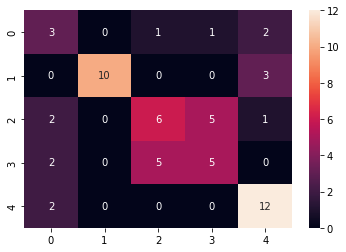

In [263]:
model = DecisionTreeClassifier(max_leaf_nodes=50, min_samples_split=2, criterion='entropy')
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot=True, fmt='.0f')
print("\nClassification Report:")
print(classification_rep)



Esta vez, los resultados no han sido del todo buenos. Igualmente, el rol de Jungla, dado los datos proporcionados, es la clase que mejor podemos identificar, con una precisión del casi 100%. El rol que le sigue, support, también es relativamente fácil de identificar, con un 70% de acierto.

De hecho, si nos paramos a pensar, tiene sentido. Dichos roles tienen una función muy característica, comparada con los laners (Top, Mid, Adc). Dichas funciones se ven muy representadas en los datos que tenemos, pero para los laners no es el caso. Desde el punto de vista de los datos obtenidos, apenas podemos diferenciar los laners entre ellos,

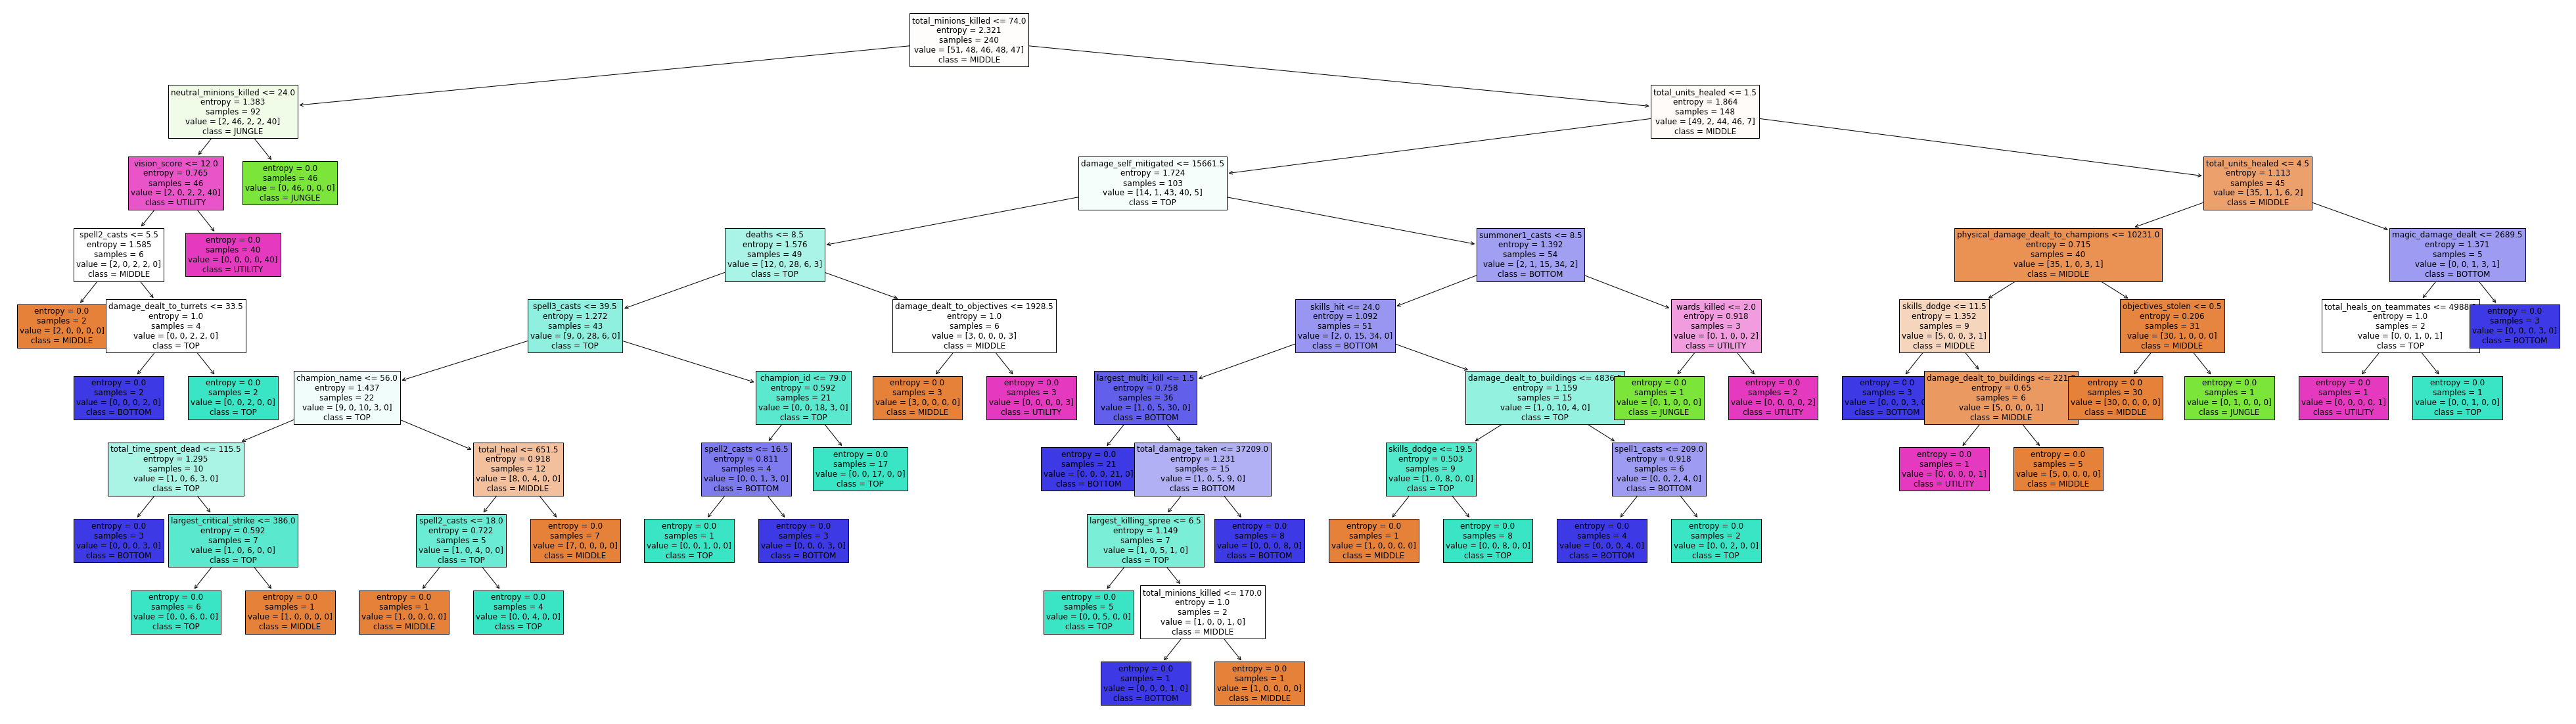

In [264]:
fig = plt.figure(figsize=(70,20))
_ = tree.plot_tree(model, 
                   feature_names=df_c.columns[:-1],  
                   class_names=df_c['individual_position'].unique(),
                   filled=True,
                   fontsize=12)

Analizando el modelo en más profundidad, los minions farmeados es la variable que mejor nos permite separar clases, junto a las unidades curadas y los monstruos neutrales eliminados. Tal y como hemos mencionado, ambas acciones son muy características de los roles Jungla y Suport (siendo la curación para el Support y la eliminación de monstruos neutrales para el Jungla). 

---------

## 3. Conclusiones

Ha sido un proceso largo y áspero, pero todo sea para vencer el +1,2% de winrate del lado azul. Según el tedioso estudio hecho en base a los 50 mejores jugadores por servidor, hemos podido observar lo siguiente:

Mediante la regresión logística, hemos concluido que derribar torretas es un factor muy relevante para ganar la partida. Mala suerte para nosotros, dicho método recalca lo obvio: Para ganar la partida hay que derribar un mínimo de 5 torretas, junto al nexo (y un inhibidor). Aun así, vamos a tener en cuenta ese dato.

Al rescate llega el Árbol de decisión, que nos da una visión más profunda de lo que puede realmente determinar la victoria (y plantear una estrategia contra el lado azul). Dicho método, nos recalca lo siguiente:

- Oro generado
- Estructuras (torretas e inhibidores)
- Experiencia de los campeones (nivel)
- Dragones totales

Por ello, podemos concluir que la estragia definitiva para ganar al lado azul es mantener un buen nivel de farmeo (para así asegurar un buen nivel de oro generado), pickear campeones que derriben torres fácilmente (Yorik, Ziggs, runa Demoler...), y tener una botside con prioridad para poder hacer los dragones.

También podemos hacer una lectura inversa, analizando las variables que se han quedado fuera. Lo que más podriamos destacar es el KDA. Según nuestro estudio, que te maten mucho o poco durante la partida no es un factor relevante a la hora de ganar la partida (por fin podré cumplir mi sueño de jugar Yasuo mid sin que me flameen). Aunque parezca una tontería, este dato puede ayudar al mental de muchos jugadores (especialmente en low elo), para poder centrarse en lo que realmente importa durante la partida: torretas y dragones.

Desde el punto de vista de Sistemas Basados en el Conocimiento, simplemente resaltar observaciones extraídas de la realización de esta entrega:

- El mito es cierto: Gran cantidad del tiempo para realizar esta entrega (y la de clustering) ha sido la limpieza y comprensión de los datos. 
- variable objetivo en el modelo: En la primera ejecución del modelo de regresión logística, este daba una accuracy del 100%. A priori pensaba que era por la gran multicolinealidad entre las variables escogidas, pero resulta que había incluido la variable objetivo (winning_team) en las métricas (X del modelo).
- sensibilidad en la forma de los datos: Lo que, a fin de cuentas, ha permitido que los dos métodos funcionasen ha estado la forma de nuestros datos. La regresión logística asume ciertas condiciones, como la linealidad y la independencia de los errores. Si estas condiciones no se cumplen, los resultados podrían haber sido sesgados.

## 4. Bibliografia

- [1] Crick, J. (n.d.). League of Legends | Lado rojo vs. Lado azul. Pinnacle. https://www.pinnacle.com/es/esports-hub/betting-articles/league-of-legends/league-of-legends-red-side-vs-blue-side/kg2jey3lv9q726yz

- [2] Intigram. (n.d.). DataCollection/turn_tabular.py at main · Intigram/DataCollection. GitHub. https://github.com/Intigram/DataCollection/blob/main/turn_tabular.py